# Identify emerging and important projects related to Red Hat using graphical analysis

In the [graph analysis notebook](./graph_analysis.ipynb), we explored relationships between open source projects and communities by studying graphs. We explored relations such as common contributors and project activities between different GitHub repositories.

In this notebook, our aim is to leverage the graph representation techniques we explored in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find important emerging projects for Red Hat.

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [1]:
import pandas as pd
import psycopg2
import itertools
import collections
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from ipynb.fs.defs.graph_helper_functions import (
     get_repos,
     get_issue_contributors,
     get_pr_contributors,
     get_commit_contributors,
     get_prr_contributors,
     created_melted_dfs,
     get_repos_outside,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
READ_LOCALLY = True

## Retrieve Available Repositories for OpenShift and Kubernetes

We start by feeding an initial list of projects out of which we track projects in 2 categories:

1. Red Hat affiliated projects (which include upstream project mappings of Red Hat products), and
2. Projects of potential interest to Red Hat

In [4]:
with open('repo_lists/red_hat_repos.txt', 'r') as f:
    rh_affiliated_projects = [line.strip() for line in f]

In [5]:
with open('repo_lists/other_repos.txt', 'r') as f:
    interesting_projects = [line.strip() for line in f]

In [6]:
with open('repo_lists/red_hat_dependencies.txt', 'r') as f:
    rh_dependencies = [line.strip() for line in f]

In [7]:
with open('repo_lists/cncf_projects.txt', 'r') as f:
    cncf = [line.strip() for line in f]

In [8]:
repo_set_interesting, repo_name_set_interesting = get_repos(interesting_projects, engine)

In [9]:
repo_set_rh_affiliated, repo_name_set_rh_affiliated = get_repos(rh_affiliated_projects, engine)

In [10]:
repo_set_rh_dep, repo_name_set_rh_dep = get_repos(rh_dependencies, engine)

In [11]:
repo_set_cncf, repo_name_set_cncf = get_repos(cncf, engine)

In [12]:
repo_set = repo_set_rh_affiliated + repo_set_interesting + repo_set_rh_dep + repo_set_cncf
repo_name_set = repo_name_set_rh_affiliated + repo_name_set_interesting + repo_name_set_rh_dep + repo_name_set_cncf

In [13]:
len(repo_name_set_rh_affiliated)

1905

In [14]:
len(repo_name_set_interesting)

1007

In [15]:
len(repo_name_set_rh_dep)

82

In [16]:
len(repo_name_set_cncf)

59

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [17]:
if READ_LOCALLY:

    issue_contrib = pd.read_pickle("ep_data/issue_contrib.pkl")

else:

    issue_contrib = get_issue_contributors(repo_set, engine)
    issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date
    date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    issue_contrib = issue_contrib.loc[date_range]
    issue_contrib.to_pickle("ep_data/issue_contrib.pkl")  

In [18]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,action,issue_id,created_at,created_at_dt
5058,32390,https://github.com/openshift/source-to-image,source-to-image,01000001-6200-0000-0000-000000000000,closed,124949,2014-05-22 18:00:49,2014-05-22
5059,32390,https://github.com/openshift/source-to-image,source-to-image,010004c7-9000-0000-0000-000000000000,closed,125140,2014-04-22 07:24:09,2014-04-22
6433,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,010000ac-6800-0000-0000-000000000000,closed,332865,2014-05-19 09:59:34,2014-05-19
6434,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332854,2013-12-20 10:37:43,2013-12-20
6462,32549,https://github.com/openshift/vagrant-openshift,vagrant-openshift,01000785-c200-0000-0000-000000000000,closed,332847,2014-05-27 11:56:24,2014-05-27


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [19]:
if READ_LOCALLY:

    pr_contrib = pd.read_pickle("ep_data/pr_contrib.pkl")

else:

    pr_contrib = get_pr_contributors(repo_set, engine)
    pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date
    date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
    pr_contrib = pr_contrib.loc[date_range]
    pr_contrib.to_pickle("ep_data/pr_contrib.pkl")

In [20]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt
139635,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28
139636,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000511-b200-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15
139637,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852920,2012-02-28 14:53:03,2012-02-28
139638,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,010005fe-ad00-0000-0000-000000000000,852921,2012-02-16 15:38:43,2012-02-16
139639,32414,https://github.com/openshift/jboss-as7-modules,jboss-as7-modules,01000c17-1100-0000-0000-000000000000,852923,2012-05-15 05:25:37,2012-05-15


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [21]:
if READ_LOCALLY:
    
    commit_contrib = pd.read_pickle("ep_data/commit_contrib.pkl")

else:
    
    commit_contrib = get_commit_contributors(repo_set, engine)
    commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date
    date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
    commit_contrib = commit_contrib.loc[date_range]
    commit_contrib.to_pickle("ep_data/commit_contrib.pkl")  

In [22]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt
12993,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856746,2013-10-21,2013-10-21
12994,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856747,2013-10-21,2013-10-21
12997,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856757,2013-11-23,2013-11-23
12998,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856758,2013-11-23,2013-11-23
13003,35833,https://github.com/RedHatInsights/go-difflib,go-difflib,010015d4-fb00-0000-0000-000000000000,3856760,2013-10-27,2013-10-27


### Retrieve PR Reviewers 

We will now fetch all the PR Reviewers for various repositories.

In [23]:
if READ_LOCALLY:

    prr_contrib = pd.read_pickle("ep_data/prr_contrib.pkl")

else:

    prr_contrib = get_prr_contributors(repo_set, engine)
    prr_contrib.to_pickle("ep_data/prr_contrib.pkl")  

In [24]:
prr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id
0,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,0100c4d7-9a00-0000-0000-000000000000,810268
1,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810290
2,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01000282-cd00-0000-0000-000000000000,810325
3,35874,https://github.com/RedHatInsights/approval-pro...,approval-process,01006b89-9b00-0000-0000-000000000000,810299
4,36052,https://github.com/RedHatInsights/vulnerabilit...,vulnerability-engine,01006579-5400-0000-0000-000000000000,55371876


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [25]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000000-0700-0000-0000-000000000000,01000000-1400-0000-0000-000000000000,01000000-1500-0000-0000-000000000000,01000000-1b00-0000-0000-000000000000,01000000-2500-0000-0000-000000000000,01000000-2e00-0000-0000-000000000000,01000000-4700-0000-0000-000000000000,01000000-6500-0000-0000-000000000000,01000000-6c00-0000-0000-000000000000,01000000-bf00-0000-0000-000000000000,...,01064248-0600-0000-0000-000000000000,010669c9-ca00-0000-0000-000000000000,01066a19-4800-0000-0000-000000000000,010685af-7f00-0000-0000-000000000000,0106b6a6-8000-0000-0000-000000000000,0106f587-7600-0000-0000-000000000000,0106ff78-e000-0000-0000-000000000000,01070d47-3700-0000-0000-000000000000,0107160e-6100-0000-0000-000000000000,010766ba-bb00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
BugzillaBugUtils,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CentOS-events,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Community-Kickstarts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Diamond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ImageStandards,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [26]:
df_commit = df_commit.reset_index()
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
154,docs,01000000-0700-0000-0000-000000000000,2
313,moby-moby,01000000-0700-0000-0000-000000000000,2
740,docs,01000000-1400-0000-0000-000000000000,2
899,moby-moby,01000000-1400-0000-0000-000000000000,2
1342,etcd,01000000-1500-0000-0000-000000000000,44


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [27]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_prr_contrib = created_melted_dfs(prr_contrib)

### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [28]:
commit_issue = pd.concat([df_melted_commit, df_melted_issue_contrib]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
comm_issue_pr_df = pd.concat([df_melted_pr_contrib, commit_issue]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
merged_df = pd.concat([comm_issue_pr_df, df_melted_prr_contrib]).groupby(["repo_name", "cntrb_id"]).sum().reset_index()
merged_df.rename(columns = {'number':'total_contributions'}, inplace = True)

In [29]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,,0100087a-3100-0000-0000-000000000000,2
1,,010044f8-fa00-0000-0000-000000000000,1
2,,01015f3b-0100-0000-0000-000000000000,1
3,3scale-amp-openshift-templates,0100025b-cb00-0000-0000-000000000000,2
4,3scale-amp-openshift-templates,01000314-4200-0000-0000-000000000000,1


### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. 

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

In [41]:
repo_scores = pd.DataFrame(
    {'repo': repo_name_set_rh_affiliated+repo_name_set_interesting+repo_name_set_rh_dep+repo_name_set_cncf 
    })

In [42]:
#  A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. 
#  Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.
bidirect_df = merged_df.append(merged_df.rename(columns={"repo_name":"cntrb_id", "cntrb_id":"repo_name"}))

In [43]:
# Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='repo_name',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

In [52]:
repos = {"repo_name_set_rh_affiliated": repo_name_set_rh_affiliated, "repo_name_set_interesting": repo_name_set_interesting, "repo_name_set_rh_dep": repo_name_set_rh_dep, "repo_name_set_cncf":repo_name_set_cncf}

In [53]:
top_repos, pageranks, repo_scores = get_page_ranks(H, 100, repos, repo_scores)

In [54]:
top_repos

defaultdict(dict,
            {'repo_name_set_rh_affiliated': {'ansible-2': 0.037474733767044806,
              'release': 0.012629494509245626,
              'docs': 0.012127892763714647,
              'kubernetes': 0.012003344840842449,
              'moby-moby': 0.007655522878784042,
              'community': 0.007032046601558561,
              'ceph-client': 0.005521178559013094,
              'ceph': 0.005405867712194782,
              'Diamond': 0.0038401594088876717,
              'openshift-docs': 0.003457218613623061,
              'etcd': 0.003048009885582067,
              'boto': 0.002584708486887508,
              'graphite-web': 0.002316112349651402,
              'infinispan-1': 0.0022785157899152205,
              'boost': 0.002118838214471124,
              'hive': 0.0020586348737005092,
              'origin': 0.001992071458065581,
              'rocksdb': 0.0019603019626667126,
              'console': 0.0019534573426694614,
              'enhancements': 0.001950027

In [55]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:100])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)

In [57]:
t = "Top 100 repos by page rank"

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

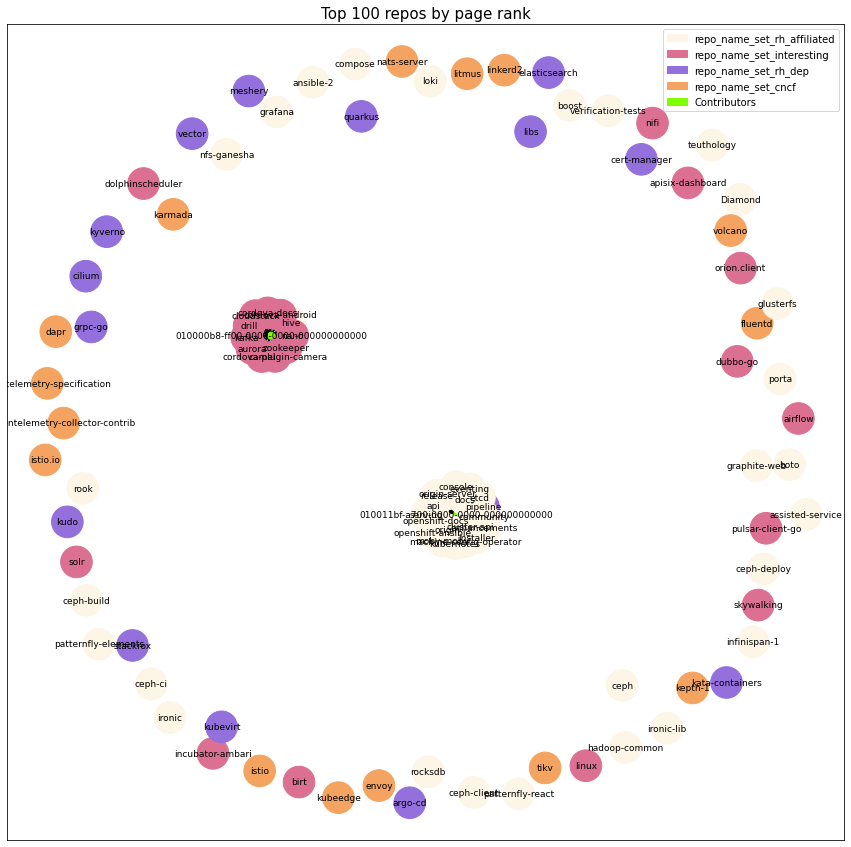

In [58]:
plot_graph(subgraph, repos, 'conditional', t, repo_name_set , True, None, 'k')

***What do we see in this plot?***



Lets look at what are the top 3 nodes

The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high. 

### Betweenness centrality

Betweenness centrality analysis provides information about the node’s importance for an information flow or connectivity of the network. 
This is a good metric for us, as using this we are able to better capture relative importance of repositories. In our case since we start with examples of well-known repos, we can use this algorithm to find other repos which are important in connection to these well-known repos.

In [59]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

In [60]:
top_repos, bc, repo_scores = get_betweenness_centrality(G, 100, repos, repo_scores)

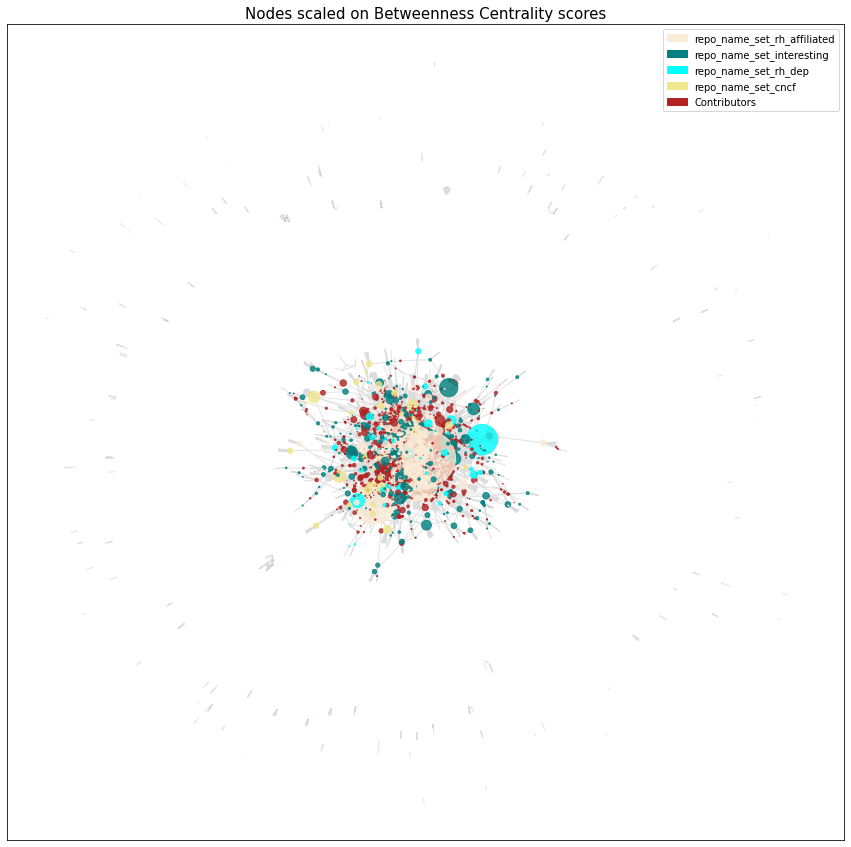

In [77]:
t = "Nodes scaled on Betweenness Centrality scores"
plot_graph(G, repos, 'weighted', t, bc , False, 0.8, "gainsboro")

## Graph Type 2: Nodes as projects edges as contributors

In [62]:
result, common_repo_contri = project_nodes_edges_contributions(merged_df)

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [81]:
g = nx.Graph()
g.add_weighted_edges_from(result)

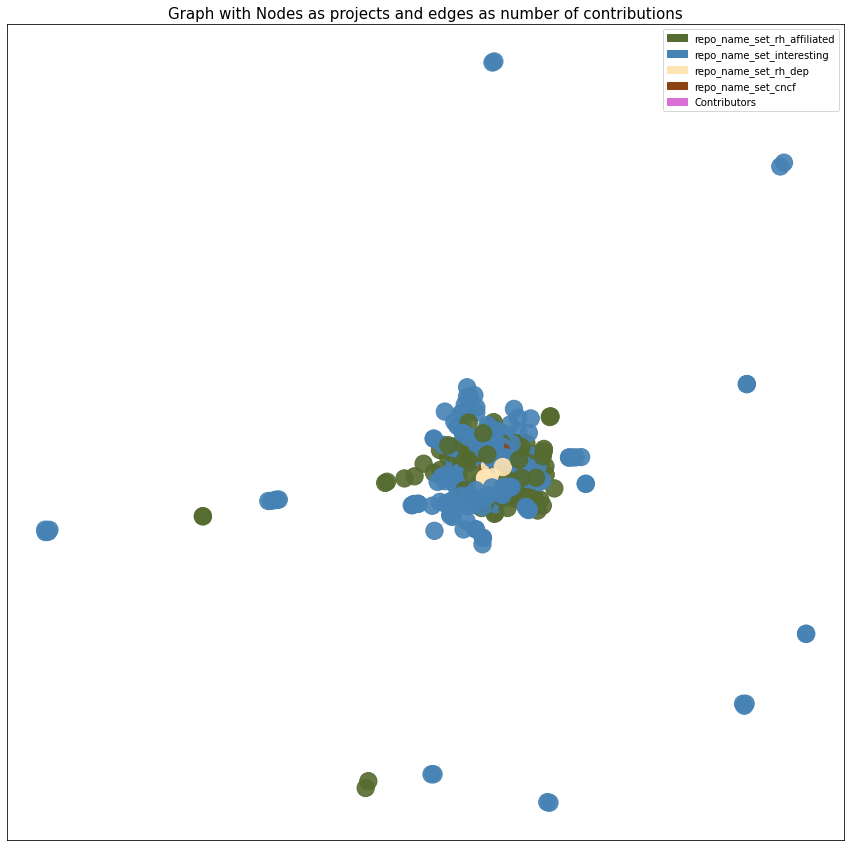

In [84]:
t = "Graph with Nodes as projects and edges as number of contributions"
plot_graph(g, repos, 'equal', t, None , False, 0.9, "gainsboro")

### Lets eliminate the 30% of the furthest connections

In [65]:
sorted_contribution_dict = dict(sorted(common_repo_contri.items(), key=lambda item: item[1], reverse=True))

In [66]:
tightly_connected_repos = dict(itertools.islice(sorted_contribution_dict.items(), round(0.7*len(sorted_contribution_dict))))

### Community Detection

To get groups of clusters, lets look at larger congregations with more than 10 projects to get a cleaner view into the main networks

In [67]:
graphs = [g.subgraph(c) for c in nx.connected_components(g)]

In [68]:
sub_graphs = []
for g in graphs:
    n = g.nodes()
    if g.number_of_nodes() > 5 and (set(n) & set(repo_name_set_interesting)):
        sub_graphs.append(g)

In [69]:
sub_graphs

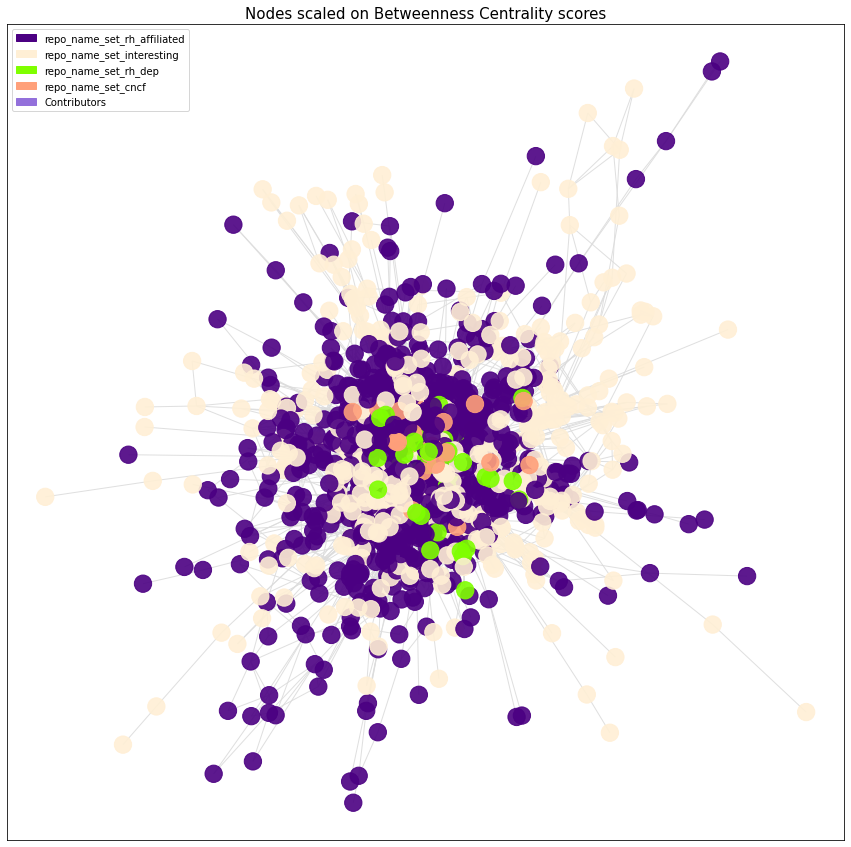

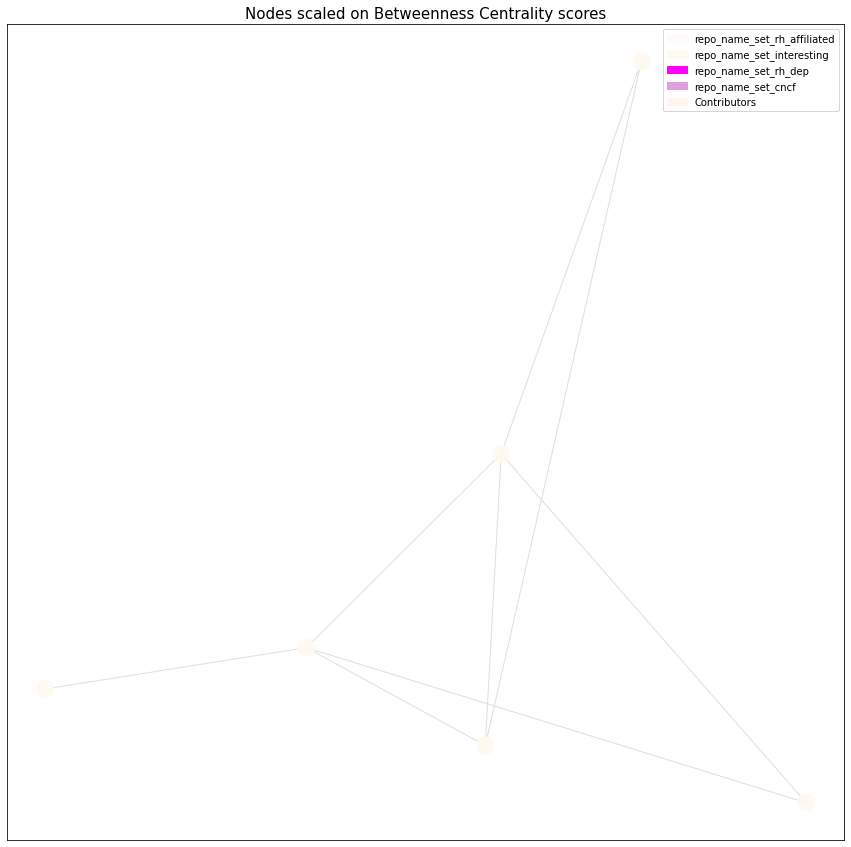

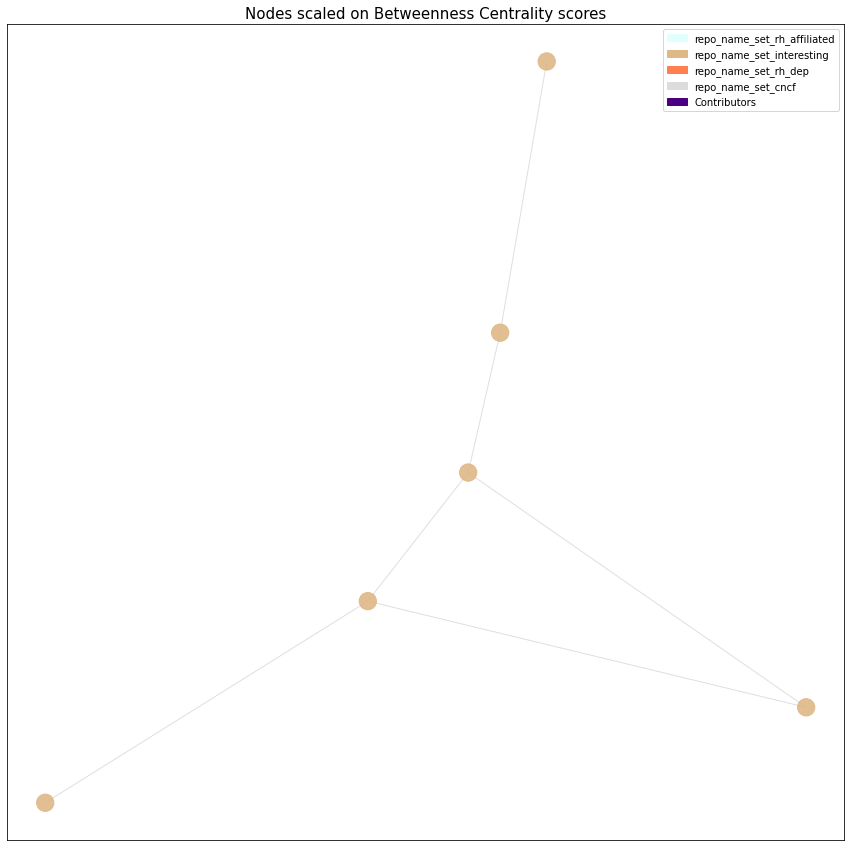

In [79]:
for graph in sub_graphs:
    plot_graph(graph, repos, 'equal', t, None , False, 0.9, "gainsboro")

In [71]:
top_repos, cc, repo_scores = get_closeness_centrality(sub_graphs[0], 100, repos, repo_scores)

In [72]:
top_repos

defaultdict(dict,
            {'repo_name_set_rh_affiliated': {'release': 0.39374042460056907,
              'kubernetes': 0.3631408962454582,
              'console': 0.3563081798375916,
              'openshift-docs': 0.3510928961748634,
              'enhancements': 0.34736435605329213,
              'ansible-2': 0.34736435605329213,
              'community': 0.3435172808860034,
              'installer': 0.3415606607176761,
              'docs': 0.3394980184940555,
              'etcd': 0.33809434316857734,
              'moby-moby': 0.33240946045824094,
              'ci-tools': 0.3317963850977499,
              'origin': 0.3314296241709654,
              'odo': 0.32954753617878735,
              'hive': 0.3294268449002014,
              'openshift-ansible': 0.32894496251599925,
              'machine-config-operator': 0.3270909090909091,
              'api': 0.3270314488274859,
              'origin-server': 0.32263271162123386,
              'serving': 0.3210206995003569,
     

In [73]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality
0,approval-process,0.000039,0.000002,0.193795
1,clowder-hello,NaN,NaN,NaN
2,insights-inventory-frontend-build,NaN,NaN,NaN
3,logger-demo,NaN,NaN,NaN
4,vmaas-go,NaN,NaN,NaN
...,...,...,...,...
3048,opentelemetry-java,0.000320,0.001924,0.222208
3049,keylime,0.000588,0.002831,0.285420
3050,strimzi-kafka-operator,0.000605,0.004736,0.296963
3051,kubedl,0.000134,0.000378,0.212497
